# Diabetes Patients Early Readmissions Prediction

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Frantisek Sefcik](https://github.com/FrantisekSefcik)

## Complementary experiments

In this jupyter notebook, we will try two approaches for prediction cross groups of similar samples.

### Setup and import libraries

In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

# Supress libraries deprecation import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, StackingClassifier

from src.preprocessing.helpers import describe_dataset
from src.evaluation import *
from sklearn.cluster import KMeans

### Load train and test data

The data from preprocessing phase will be used.

In [4]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [5]:
X_train, y_train = undersample(X_train, y_train)

In [6]:
describe_dataset(X_train, X_test, y_train, y_test)

Number of train data: 18188
Number of test data: 20353
Number of features: 53
Classes:
	0 :
	    train: 9094 samples, 50.0%
	    test: 18090 samples, 89.0%

	1 :
	    train: 9094 samples, 50.0%
	    test: 2263 samples, 11.0%



### 1. Classification cross age

#### Histogram of age

Histogram of age attribute helps to select age threshold for 3 age groups.

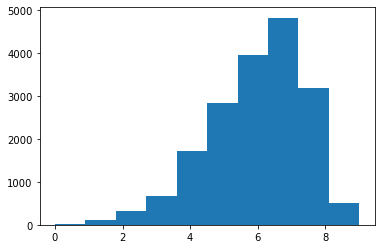

In [7]:
counts, bins = np.histogram(X_train['age'])
plt.hist(bins[:-1], bins, weights=counts);

#### Divide data into age groups

We specified intervals for age groups to obtain most accurate balanced datasets.

Groups:
* 20: <0,  50)
* 50: <50, 70)
* 70: <70, 90)

In [8]:
def less(x, y, t):
    x_l = x[x['age'] < t]
    return x_l, y.loc[x_l.index]

def more(x, y, t):
    x_l = x[x['age'] > t]
    return x_l, y.loc[x_l.index]

In [9]:
X_train_70, y_train_70 = more(X_train, y_train, 6)
X_test_70, y_test_70 = more(X_test, y_test, 6)

X_train_20, y_train_20 = less(X_train, y_train, 5)
X_test_20, y_test_20 = less(X_test, y_test, 5)

X_train_50, y_train_50 = more(*less(X_train, y_train, 7), 4)
X_test_50, y_test_50 = more(*less(X_test, y_test, 7), 4)

In [10]:
print("Number of data into groups:")
print("< 0,50): ", X_train_20.shape[0])
print("<50,70): ", X_train_50.shape[0])
print("<70,90): ", X_train_70.shape[0])

Number of data into groups:
< 0,50):  2855
<50,70):  6816
<70,90):  8517


#### Train models

We will use base model from model selection phase which obtain best results. Three Random forest model will be train with preprared data individualy for each age interval. 

##### 1. Gorup <0, 50)

              precision    recall  f1-score   support

           0       0.93      0.71      0.81      2844
           1       0.17      0.55      0.26       315

    accuracy                           0.70      3159
   macro avg       0.55      0.63      0.54      3159
weighted avg       0.86      0.70      0.75      3159

ROC AUC score: 0.63


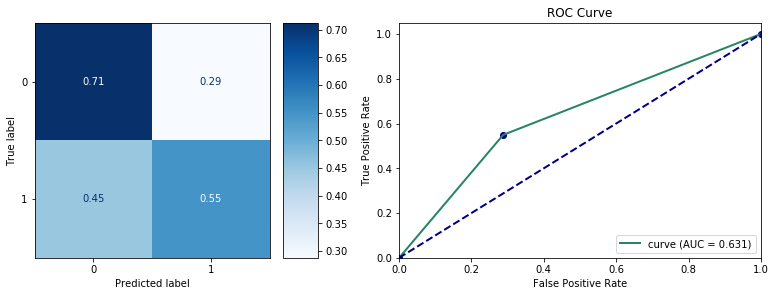

In [11]:
rf_20 = RandomForestClassifier(max_depth=7, random_state=42, class_weight="balanced")
rf_20.fit(X_train_20, y_train_20)
evaluate_model(rf_20, X_test_20, y_test_20)

##### 2. Gorup <50, 70)

              precision    recall  f1-score   support

           0       0.93      0.62      0.75      7134
           1       0.17      0.62      0.27       905

    accuracy                           0.62      8039
   macro avg       0.55      0.62      0.51      8039
weighted avg       0.84      0.62      0.69      8039

ROC AUC score: 0.62


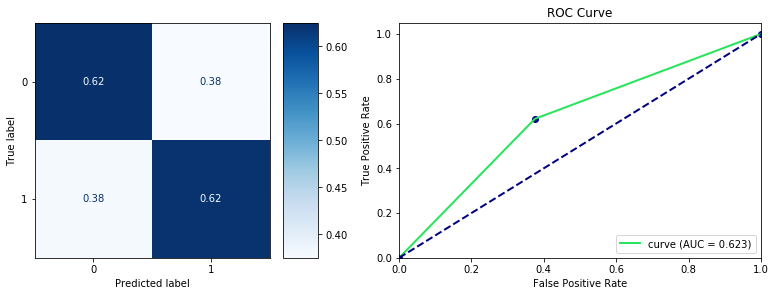

In [12]:
rf_50 = RandomForestClassifier(max_depth=8, random_state=42, class_weight="balanced")
rf_50.fit(X_train_50, y_train_50)
evaluate_model(rf_50, X_test_50, y_test_50)

##### 2. Gorup <70, 90)

              precision    recall  f1-score   support

           0       0.91      0.54      0.68      8112
           1       0.15      0.60      0.23      1043

    accuracy                           0.55      9155
   macro avg       0.53      0.57      0.46      9155
weighted avg       0.83      0.55      0.63      9155

ROC AUC score: 0.57


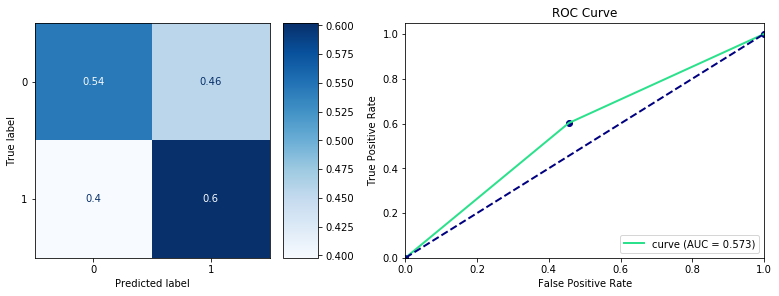

In [13]:
rf_70 = RandomForestClassifier(max_depth=9, random_state=42, class_weight="balanced")
rf_70.fit(X_train_70, y_train_70)
evaluate_model(rf_70, X_test_70, y_test_70)

#### Combined model

Three models will be combined into one model called CombinedModel. We created this new type of models embeding which contains several models. During prediction from all models is selected one with rules in ruler function. In this case, for each sample in test data is selected model of apropriate age interval.

In [14]:
def ruler(x):
    if x['age'] <= 4:
        return 0
    elif x['age'] > 4 and x['age'] <= 6:
        return 1
    elif x['age'] > 6:
        return 2

In [15]:
cls = CombinedModel([rf_20, rf_50, rf_70], ruler)
cls.fit(X_train, y_train);

In [16]:
pred = cls.predict(X_test)

              precision    recall  f1-score   support

           0       0.92      0.60      0.73     18090
           1       0.16      0.60      0.25      2263

    accuracy                           0.60     20353
   macro avg       0.54      0.60      0.49     20353
weighted avg       0.84      0.60      0.68     20353

ROC AUC score: 0.6


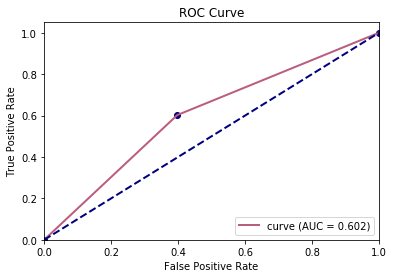

In [17]:
print(classification_report(y_test, pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, pred), 2)}')
roc_auc(pred, y_test);

##### Conclusion

In the first experiment we created own model ensemble by combination of three models, each trained for individual patient age range. We did not achieve better results as best model from model selection phase but we made some observations. 

Results from individual age interval training shows trend, that performence of model decrease with increasing age. This observation was also mentioned in several related papers. For patients under 50 age model achieved best results campared to prediction on all age patients.

### 2. Classification cross clusters

As above data were divided with age rule, in the next experiment data will by divided to the clusters by the clustering model KMeans. With each individual cluster medel will be trained.

#### Train KMeans and divide data to clusters

In [18]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_train)

In [19]:
clusters = kmeans.predict(X_train)
clusters_test = kmeans.predict(X_test)
X_train_1, y_train_1 = X_train[clusters == 0], y_train[clusters == 0]
X_test_1, y_test_1 = X_test[clusters_test == 0], y_test[clusters_test == 0]

X_train_2, y_train_2 = X_train[clusters == 1], y_train[clusters == 1]
X_test_2, y_test_2 = X_test[clusters_test == 1], y_test[clusters_test == 1]

X_train_3, y_train_3 = X_train[clusters == 2], y_train[clusters == 2]
X_test_3, y_test_3 = X_test[clusters_test == 2], y_test[clusters_test == 2]

In [20]:
print("Number of data into groups:")
print("cluster 1: ", X_train_1.shape[0])
print("cluster 2: ", X_train_2.shape[0])
print("cluster 3: ", X_train_3.shape[0])

Number of data into groups:
cluster 1:  8676
cluster 2:  6021
cluster 3:  3491


##### 1. Cluster 1

              precision    recall  f1-score   support

           0       0.93      0.55      0.69      8648
           1       0.16      0.66      0.25      1091

    accuracy                           0.56      9739
   macro avg       0.54      0.60      0.47      9739
weighted avg       0.84      0.56      0.64      9739

ROC AUC score: 0.6


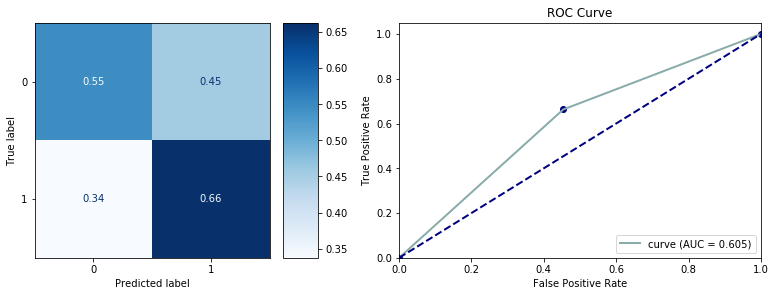

In [21]:
rf_1 = RandomForestClassifier(max_depth=7, random_state=42, class_weight="balanced")
rf_1.fit(X_train_1, y_train_1)
evaluate_model(rf_1, X_test_1, y_test_1)

##### 2. Cluster 2

              precision    recall  f1-score   support

           0       0.91      0.64      0.75      5694
           1       0.18      0.56      0.27       791

    accuracy                           0.63      6485
   macro avg       0.54      0.60      0.51      6485
weighted avg       0.82      0.63      0.69      6485

ROC AUC score: 0.6


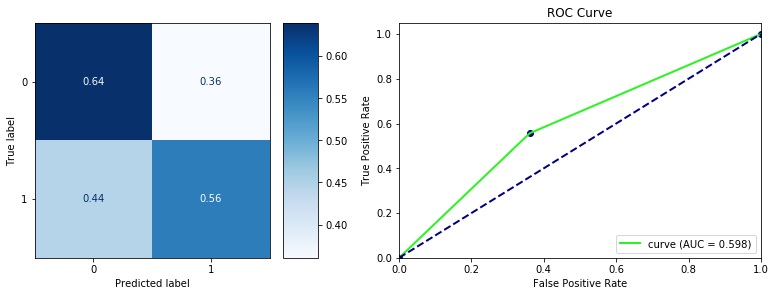

In [22]:
rf_2 = RandomForestClassifier(max_depth=6, random_state=42, class_weight="balanced")
rf_2.fit(X_train_2, y_train_2)
evaluate_model(rf_2, X_test_2, y_test_2)

##### 3. Cluster 3

              precision    recall  f1-score   support

           0       0.94      0.63      0.75      3748
           1       0.14      0.60      0.23       381

    accuracy                           0.62      4129
   macro avg       0.54      0.62      0.49      4129
weighted avg       0.87      0.62      0.70      4129

ROC AUC score: 0.62


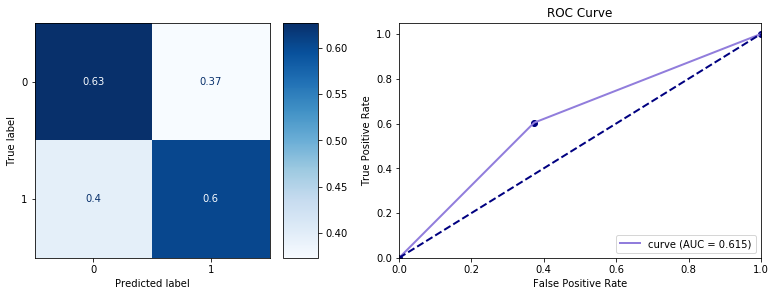

In [23]:
rf_3 = RandomForestClassifier(max_depth=5, random_state=42, class_weight="balanced")
rf_3.fit(X_train_3, y_train_3)
evaluate_model(rf_3, X_test_3, y_test_3)

#### Combined model

Same medels embeding as in the first experiment will be used. One difference is in ruler definition where index of model is defined as predicted cluster.

In [24]:
def ruler(x):
    return kmeans.predict([x])

In [25]:
cls = CombinedModel([rf_1, rf_2, rf_3], ruler)

In [26]:
pred = cls.predict(X_test)

              precision    recall  f1-score   support

           0       0.92      0.59      0.72     18090
           1       0.16      0.62      0.25      2263

    accuracy                           0.59     20353
   macro avg       0.54      0.60      0.49     20353
weighted avg       0.84      0.59      0.67     20353

ROC AUC score: 0.6


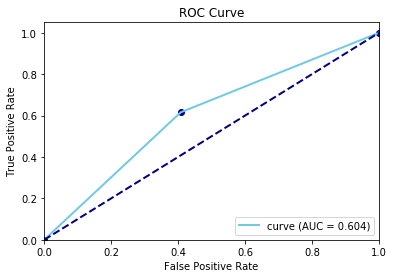

In [27]:
print(classification_report(y_test, pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, pred), 2)}')
roc_auc(pred, y_test);

#### Conclusion

With combination of models on individual clusters we did not achieve better results as the base model, but results are comparable. Performence of models cross clusters are almost the same, what could means that data are not clearly divided to some groups characterized by their features. 